# Assignment 4: Trip Duration of CitiBike users during the day vs. night

HW is split into two parts. **Part 1** covers data import, cleanup, and sampling. **Part 2** covers the three correlation tests:
1. Pearson’s test 
2. Spearman’s test 
3. K-S test

# Part 1: Data Import, Cleanup, and Sampling

In [192]:
# my usual imports and setups
import pylab as pl
import pandas as pd
import numpy as np
%pylab inline

import os
from datetime import datetime
import scipy.stats

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [193]:
def getCitiBikeCSV(date):
    ''' 
    This function returns citi bike data for a given month(s)
    
    Parameters
    ----------
    date: string
        Pass one month by inputting format <YYYY><MM>; EX: 201801
        Pass month range by inputting format <YYYY><M1M1><M2M2>; EX: 20180103
        
    Returns
    ----------
    csv: table
        dumps it into your PUIDATA folder
    '''
    path = "https://s3.amazonaws.com/tripdata/{}-citibike-tripdata.csv.zip".format(date)
    os.system('curl -O ' + path)
    currentpath = !pwd
    os.system('unzip -u '+currentpath[0]+'/'+ path.split('/')[-1]+ ' -d $PUIDATA')
    print('Downloaded',path.split('/')[-1].split('.z')[0], 'to your PUIDATA folder!')

In [194]:
## Downloading data for January and July
datestring = '201801'
datestring2 = '201806'
getCitiBikeCSV(datestring)
getCitiBikeCSV(datestring2)
df = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv', parse_dates=['starttime','stoptime'])
df2 = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring2 + '-citibike-tripdata.csv', parse_dates=['starttime','stoptime'])
df_combined = pd.concat([df,df2])
df_combined.head(3)

Downloaded 201801-citibike-tripdata.csv to your PUIDATA folder!
Downloaded 201806-citibike-tripdata.csv to your PUIDATA folder!


,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72,W 52 St & 11 Ave,40.767272,-73.993929,505,6 Ave & W 33 St,40.749013,-73.988484,31956,Subscriber,1992,1
1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72,W 52 St & 11 Ave,40.767272,-73.993929,3255,8 Ave & W 31 St,40.750585,-73.994685,32536,Subscriber,1969,1
2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72,W 52 St & 11 Ave,40.767272,-73.993929,525,W 34 St & 11 Ave,40.755942,-74.002116,16069,Subscriber,1956,1


In [195]:
#Calculate 'Mean_Hour' and separate trip duration into two columns (Day vs Night)
df_combined['meanHour'] = (df_combined['starttime'] + (df_combined['stoptime'] - df_combined['starttime'])/2).dt.hour
df_clean = df_combined[['tripduration','meanHour']]
df_clean.reset_index(inplace=True)
df_clean['trip_night'] = df_clean['tripduration'][(df_clean.meanHour<4) | (df_clean.meanHour>18)]
df_clean['trip_day'] = df_clean['tripduration'][(df_clean.meanHour>4) & (df_clean.meanHour<18)]
df_clean.describe()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


,index,tripduration,meanHour,trip_night,trip_day
count,2.672097e+06,2.672097e+06,2.672097e+06,5.726430e+05,1.833085e+06
mean,8.105172e+05,1.107858e+03,1.408728e+01,1.328313e+03,1.041987e+03
std,5.646468e+05,2.772001e+04,4.889679e+00,3.796838e+04,2.482337e+04
min,0.000000e+00,6.100000e+01,0.000000e+00,6.100000e+01,6.100000e+01
25%,3.340120e+05,3.640000e+02,1.000000e+01,NaN,NaN
50%,6.680240e+05,6.120000e+02,1.500000e+01,NaN,NaN
75%,1.285078e+06,1.071000e+03,1.800000e+01,NaN,NaN
max,1.953102e+06,1.951005e+07,2.300000e+01,1.169975e+07,1.951005e+07


In [207]:
#selected sample of 200 from each group (day and night)
np.random.seed(1992)
sample_size = 200

#Separate into 2 dataframes
df_day = df_clean[df_clean.trip_day.notnull()].reset_index()
df_night =  df_clean[df_clean.trip_night.notnull()].reset_index()
i = np.random.choice((range(len(df_day))),size=sample_size,replace=True) # returns array of indices
i2 = np.random.choice((range(len(df_night))),size=sample_size,replace=True)

# use array of indices to select from dataframes
sample_day = df_day.ix[i] 
sample_night = df_night.ix[i2]

#sort values by trip duration
sample_day.sort_values('tripduration',ascending=True,inplace=True)
sample_night.sort_values('tripduration',ascending=True,inplace=True)

# Part 2: Correlation Tests

## Kolmogorov-Smirnov (KS) Test (for both full population and 200 sample size)

### Question: 
Is there a difference in the duration of night trips vs day trips?

### Null Hypothesis:
There is no statistical difference in the trip duration of night trips (6pm-4am) vs day trips (4am to 6am), **significance level= 0.05 **

$H_0: P_0=P_1$

$P_0$: Distribution of riders during the day

$P_1$: Distribution of riders at night

### Alternative Hypothesis:
There is a statistical difference between the two groups
$H_a: P_0>P_1;P_0<P_1$

### Using Entire Population

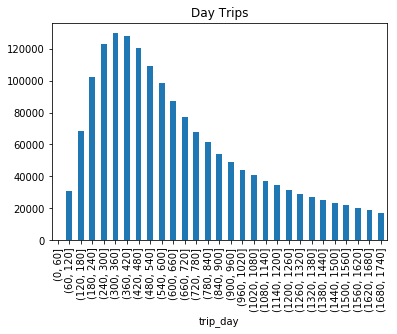

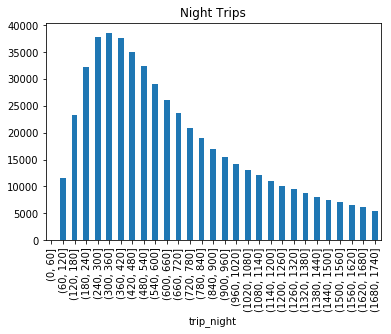

In [208]:
#What do the individual distributions look like for day vs night?                        
bins = np.arange(0, 1800, 60)
axD = df_clean.trip_day.groupby(pd.cut(df_clean.trip_day, bins)).agg([count_nonzero]).plot(kind='bar', legend=False)
axD.set_title("Day Trips")
axN = df_clean.trip_night.groupby(pd.cut(df_clean.trip_night, bins)).agg([count_nonzero]).plot(kind='bar',legend=False)
axN.set_title("Night Trips");


**Figure 1: Histogrammed distributions of riders ages by gender**. Notice that both graphs are positively skewed and visually look like similar distributions. I plotted these to see if night rides followed a distribution pattern than day rides (by trip duration). 

              count_nonzero
trip_day                   
(0, 60]            0.000000
(60, 120]          0.003823
(120, 180]         0.008081
(180, 240]         0.009028
(240, 300]         0.008317
(300, 360]         0.005190
(360, 420]         0.001569
(420, 480]         0.002496
(480, 540]         0.005127
(540, 600]         0.007552
(600, 660]         0.009058
(660, 720]         0.009461
(720, 780]         0.009546
(780, 840]         0.009605
(840, 900]         0.009166
(900, 960]         0.008453
(960, 1020]        0.007608
(1020, 1080]       0.006966
(1080, 1140]       0.005856
(1140, 1200]       0.005393
(1200, 1260]       0.004866
(1260, 1320]       0.003849
(1320, 1380]       0.003318
(1380, 1440]       0.002827
(1440, 1500]       0.002422
(1500, 1560]       0.001782
(1560, 1620]       0.001113
(1620, 1680]       0.000479
(1680, 1740]       0.000000


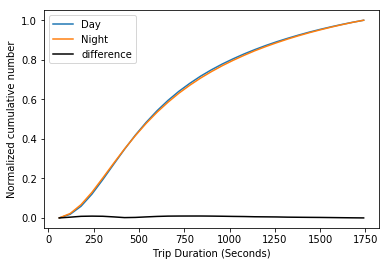

In [209]:
csD = df_clean.trip_day.groupby(pd.cut(df_clean.trip_day, bins)).agg([count_nonzero]).cumsum()
csN = df_clean.trip_night.groupby(pd.cut(df_clean.trip_night, bins)).agg([count_nonzero]).cumsum()
print(np.abs(csD/csD.max() - csN/csN.max()))
pl.plot(bins[:-1]+60, csD/csD.max(),label='Day')
pl.plot(bins[:-1]+60, csN/csN.max(),label='Night')
pl.plot(bins[:-1] + 60, np.abs(csD/csD.max() - csN/csN.max()), 'k-', #plot absolute value of difference
        label = "difference")
pl.xlabel('Trip Duration (Seconds)')
pl.ylabel('Normalized cumulative number')
pl.legend()

**Figure 2: Cumulative distribution of CitiBike Trip Durations by Day/Night**. Notice that they look very similar but the difference gets to 0.96% (from 13 to 14 minutes). 

In [210]:
ks = scipy.stats.ks_2samp(df_clean.trip_day,df_clean.trip_night)
print(ks)

Ks_2sampResult(statistic=0.47172389325686903, pvalue=0.0)


In [211]:
def calc_CA(x,y):
    n_m, n_f, ca = len(x),len(y), 1.36 # n observations for each, 1.36 comes from c(a) table below
    return(ca*np.sqrt((n_m+n_f)/(n_m*n_f))) # equation for comparison value
CA_val = calc_CA(df_clean.trip_day,df_clean.trip_night)

print('KS-Statistic: ',ks.statistic)
print('P-Value: ',ks.pvalue)
print('Comparison value: ',CA_val)
print('Do We Reject the null: ', ks.statistic>CA_val)

KS-Statistic:  0.471723893257
P-Value:  0.0
Comparison value:  0.0011765971619
Do We Reject the null:  True


### KS Testing Conclusions - Entire Population
Using an alpha level of 0.05, **we were able to reject the null**. The KS scipy package returned a ks statistic of 0.47 (relatively high), and a p-value of 0.00. When then compare the ks-stat to the result of $c(\alpha)\sqrt{\frac{(n1 + n2)}{n1n2}}$, 
* $D_{n1,n2} > c(\alpha) \sqrt{\frac{(n1 + n2)}{n1n2}}$; 
* $0.47>0.0012$

Therefore, night time trip durations are **significantly different** than day time trip durations

### Using Samples of 200

In [212]:
ks2 = scipy.stats.ks_2samp(sample_day.trip_day,sample_night.trip_night)
CA_val2 = calc_CA(sample_day.trip_day,sample_day.trip_night)

print('KS-Statistic: ',ks2.statistic)
print('P-Value: ',ks2.pvalue)
print('Comparison value: ',CA_val2)
print('Do We Reject the null: ', ks2.statistic>CA_val2)

KS-Statistic:  0.105
P-Value:  0.20781055046
Comparison value:  0.136
Do We Reject the null:  False


### KS Testing Conclusions - Samples of 200
We **failed to reject the null** using our sample sizes of 200 for day and night. The KS scipy package returned a ks statistic of 0.105, and a p-value of 0.208. When then compare the ks-stat to the result of $c(\alpha)\sqrt{\frac{(n1 + n2)}{n1n2}}$, 
* $D_{n1,n2} > c(\alpha) \sqrt{\frac{(n1 + n2)}{n1n2}}$; 
* $0.105<0.136$

Therefore, night time trip durations are ** not significantly different** than day time trip durations. **This is the inverse of our KS test using the entire population** and shows that when we reduce our datasets, we are unable to determine differences between the two. 

# Pearsons Test

### Null Hypothesis:
There is no linear relationship between the trip duration of night trips (6pm-4am) vs day trips (4am to 6am), **significance level= 0.05 **

$H_0: r_{pb}=0$


$r_{pb}$: r coefficient of correlation between day and night trips

### Alternative Hypothesis:
There is a linear relationship between the two groups

$H_a: \mid{r_{pb}}\mid>0$

In [213]:
# use scipy package to calculate pearsons
pearsons = scipy.stats.pearsonr(sample_day.tripduration,sample_night.tripduration)
print('Pearsons R: ',pearsons[0],'\nP Value: ',pearsons[1])

Pearsons R:  0.944419446864 
P Value:  1.30376917709e-97


### Interpretation of Pearsons Test
* The correlation coefficient was extremely high at 0.944. This makes sense since both sample sizes are sorted by trip duration.
* The p-value was essentially 0.00, but the documentation states that its only reliable at sample sizes of 500+
* We therefore can **reject the null** since day trips and night trips are extremely correlated.

## Spearmans Test for Correlation

### Null Hypothesis:
There is no monotonic correlation between the trip duration of night trips (6pm-4am) vs day trips (4am to 6am)

$H_0: r_{pb}=0$

$r_{pb}$: r coefficient of correlation between day and night trips


### Alternative Hypothesis:
There is a correlation between the two groups

$H_a: \mid{r_{pb}}\mid>0$

In [214]:
spearmans = scipy.stats.spearmanr(sample_day.tripduration,sample_night.tripduration)
print('Spearmans R: ',spearmans.correlation,'\nP Value: ',spearmans.pvalue)

Spearmans R:  0.999987999568 
P Value:  0.0


### Interpretation of Spearmans Test Results
* The correlation coefficient was extremely high at 0.9999. This makes sense since both sample sizes are sorted by trip duration.
* Unlike Pearsons, Spearmans test doesn't assume that both samples are normally distributed and doesn't only look at linear relationships
* Since Spearmans R is greater than Pearsons R, the relationship between the two groups is non-linear
* The p-value was essentially 0.0, meaning there is no uncertainty about the correlation.
* We therefore can **reject the null** since day trips and night trips are extremely correlated.